In [6]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data


%matplotlib inline
np.random.seed(1)

Using TensorFlow backend.


y = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(60000, 28, 28, 1)
(10, 60000)


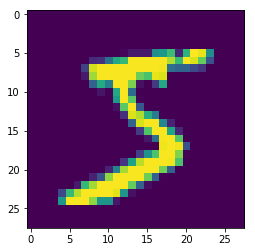

In [7]:
from keras.datasets import mnist
import keras


(x_train,train_y),(x_test,test_y)=mnist.load_data()
#print(x_train.shape)
#x_train=np.reshape(x_train,[60000,784])
#x_test=np.reshape(x_test,[10000,784])
train_y=np.reshape(train_y,(60000,1))
test_y=np.reshape(test_y,(10000,1))

y_train = keras.utils.to_categorical(train_y, num_classes=None, dtype='float32')
y_train=y_train.T

y_test = keras.utils.to_categorical(test_y, num_classes=None, dtype='float32')
y_test=y_test.T




index = 0
plt.imshow(x_train[index])
print ("y = " + str(np.squeeze(y_train[:,index])))


x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
x_train=x_train/255.0
x_test=x_test/255.0

print(x_train.shape)
print(y_train.shape)

In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    ### END CODE HERE ###
    
    return X, Y

In [9]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [10]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    
    tf.set_random_seed(1)                            
    W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [11]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)
    return Z3

In [1]:
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    
    shuffled_Y = Y[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [14]:

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    print(Y_train.shape)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[0]                            
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
    
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            minibatches = random_mini_batches(X_train, Y_train.T, minibatch_size)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch    # Select a minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost 
                
            minibatch_cost=minibatch_cost/ num_minibatches
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train.T})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test.T})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

(10, 60000)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.443741
Cost after epoch 5: 0.142184
Cost after epoch 10: 0.130707
Cost after epoch 15: 0.127966
Cost after epoch 20: 0.126298
Cost after epoch 25: 0.125364
Cost after epoch 30: 0.122639
Cost after epoch 35: 0.120819
Cost after epoch 40: 0.124927
Cost after epoch 45: 0.120461
Cost after epoch 50: 0.118730
Cost after epoch 55: 0.119003
Cost after epoch 60: 0.118970
Cost after epoch 65: 0.117963
Cost after epoch 70: 0.122932
Cost after epoch 75: 0.115618
Cost after epoch 80: 0.117950
Cost after epoch 85: 0.116419
Cost after epoch 90: 0.116979
Cost after epoch 95: 0.117850


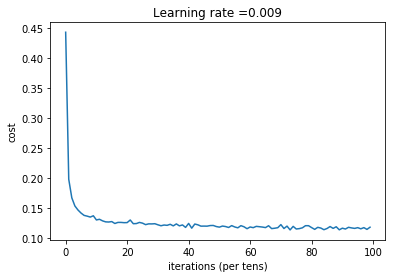

Tensor("Mean_1:0", shape=(), dtype=float32)
('Train Accuracy:', 0.95765)
('Test Accuracy:', 0.9563)


In [15]:
_, _, parameters = model(x_train, y_train, x_test, y_test)